<h1><center> Exploratory Data Analysis Notebook

<h3> Data Loading

In [ ]:
import os
import pandas as pd

import pandas as pd

price_df = pd.read_csv("../data/price.csv")
news_df  = pd.read_csv("../data/news.csv")


# ---------- Basic validation ----------
required_price_cols = {'date', 'ticker', 'open', 'high', 'low', 'close', 'volume'}
required_news_cols  = {'datetime', 'ticker', 'headline', 'summary'}

missing_price = required_price_cols - set(price_df.columns)
missing_news  = required_news_cols  - set(news_df.columns)
if missing_price:
    raise ValueError(f"Missing columns in price_df: {missing_price}")
if missing_news:
    raise ValueError(f"Missing columns in news_df: {missing_news}")

# ---------- Types & cleaning ----------
price_df['date'] = pd.to_datetime(price_df['date'])
news_df['datetime'] = pd.to_datetime(news_df['datetime'], errors='coerce')

# Drop news rows with bad timestamps
news_df = news_df.dropna(subset=['datetime'])

# Normalize tickers (upper-case) and drop exact dupes
price_df['ticker'] = price_df['ticker'].str.upper()
news_df['ticker']  = news_df['ticker'].str.upper()

news_df = news_df.drop_duplicates(subset=['ticker', 'datetime', 'headline', 'summary']).copy()

# Derive the calendar date for grouping
news_df['date'] = pd.to_datetime(news_df['datetime'].dt.date)


Merged data (sample):
        date ticker        open        high         low       close    volume  \
0 2023-11-13   AAPL  185.820007  186.029999  184.210007  184.800003  43627500   
1 2023-11-14   AAPL  187.699997  188.110001  186.300003  187.440002  60108400   
2 2023-11-15   AAPL  187.850006  189.500000  187.779999  188.009995  53790500   
3 2023-11-16   AAPL  189.570007  190.960007  188.649994  189.710007  54412900   
4 2023-11-17   AAPL  190.250000  190.380005  188.570007  189.690002  50922700   

                                     aggregated_text  \
0  GPU tech supplier Imagination Technologies lay...   
1  Apple supplier Foxconn's Q3 profit rises 11%, ...   
2                                                      
3  Apple's Effort To Replace Qualcomm Chip In iPh...   
4  K-pop star Rosé joins first lady Jill Biden to...   

                                            headline  \
0  GPU tech supplier Imagination Technologies lay...   
1  Apple supplier Foxconn's Q3 profit rise

Number of unique tickers: 7
List of tickers:
['AAPL', 'AMZN', 'GOOGL', 'META', 'MSFT', 'NVDA', 'TSLA']
Categories (7, object): ['AAPL', 'AMZN', 'GOOGL', 'META', 'MSFT', 'NVDA', 'TSLA']

Number of rows per ticker (top 10):
ticker
AAPL     241
AMZN     241
GOOGL    241
META     241
MSFT     241
NVDA     241
TSLA     241
Name: count, dtype: int64


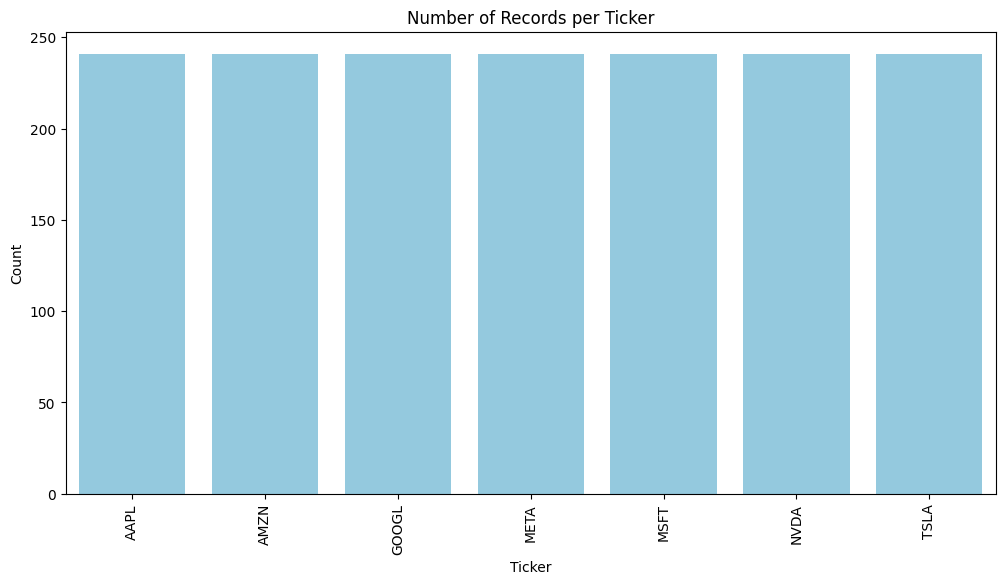

In [18]:
# --- Exploratory Data Analysis: Tickers ---

# Unique tickers
unique_tickers = df['ticker'].unique()
num_tickers = df['ticker'].nunique()

print(f"Number of unique tickers: {num_tickers}")
print("List of tickers:")
print(unique_tickers)

# Extra: distribution of rows per ticker
ticker_counts = df['ticker'].value_counts()

print("\nNumber of rows per ticker (top 10):")
print(ticker_counts.head(10))

# Optional: quick barplot
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.barplot(x=ticker_counts.index, y=ticker_counts.values, color="skyblue")
plt.title("Number of Records per Ticker")
plt.xlabel("Ticker")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.show()


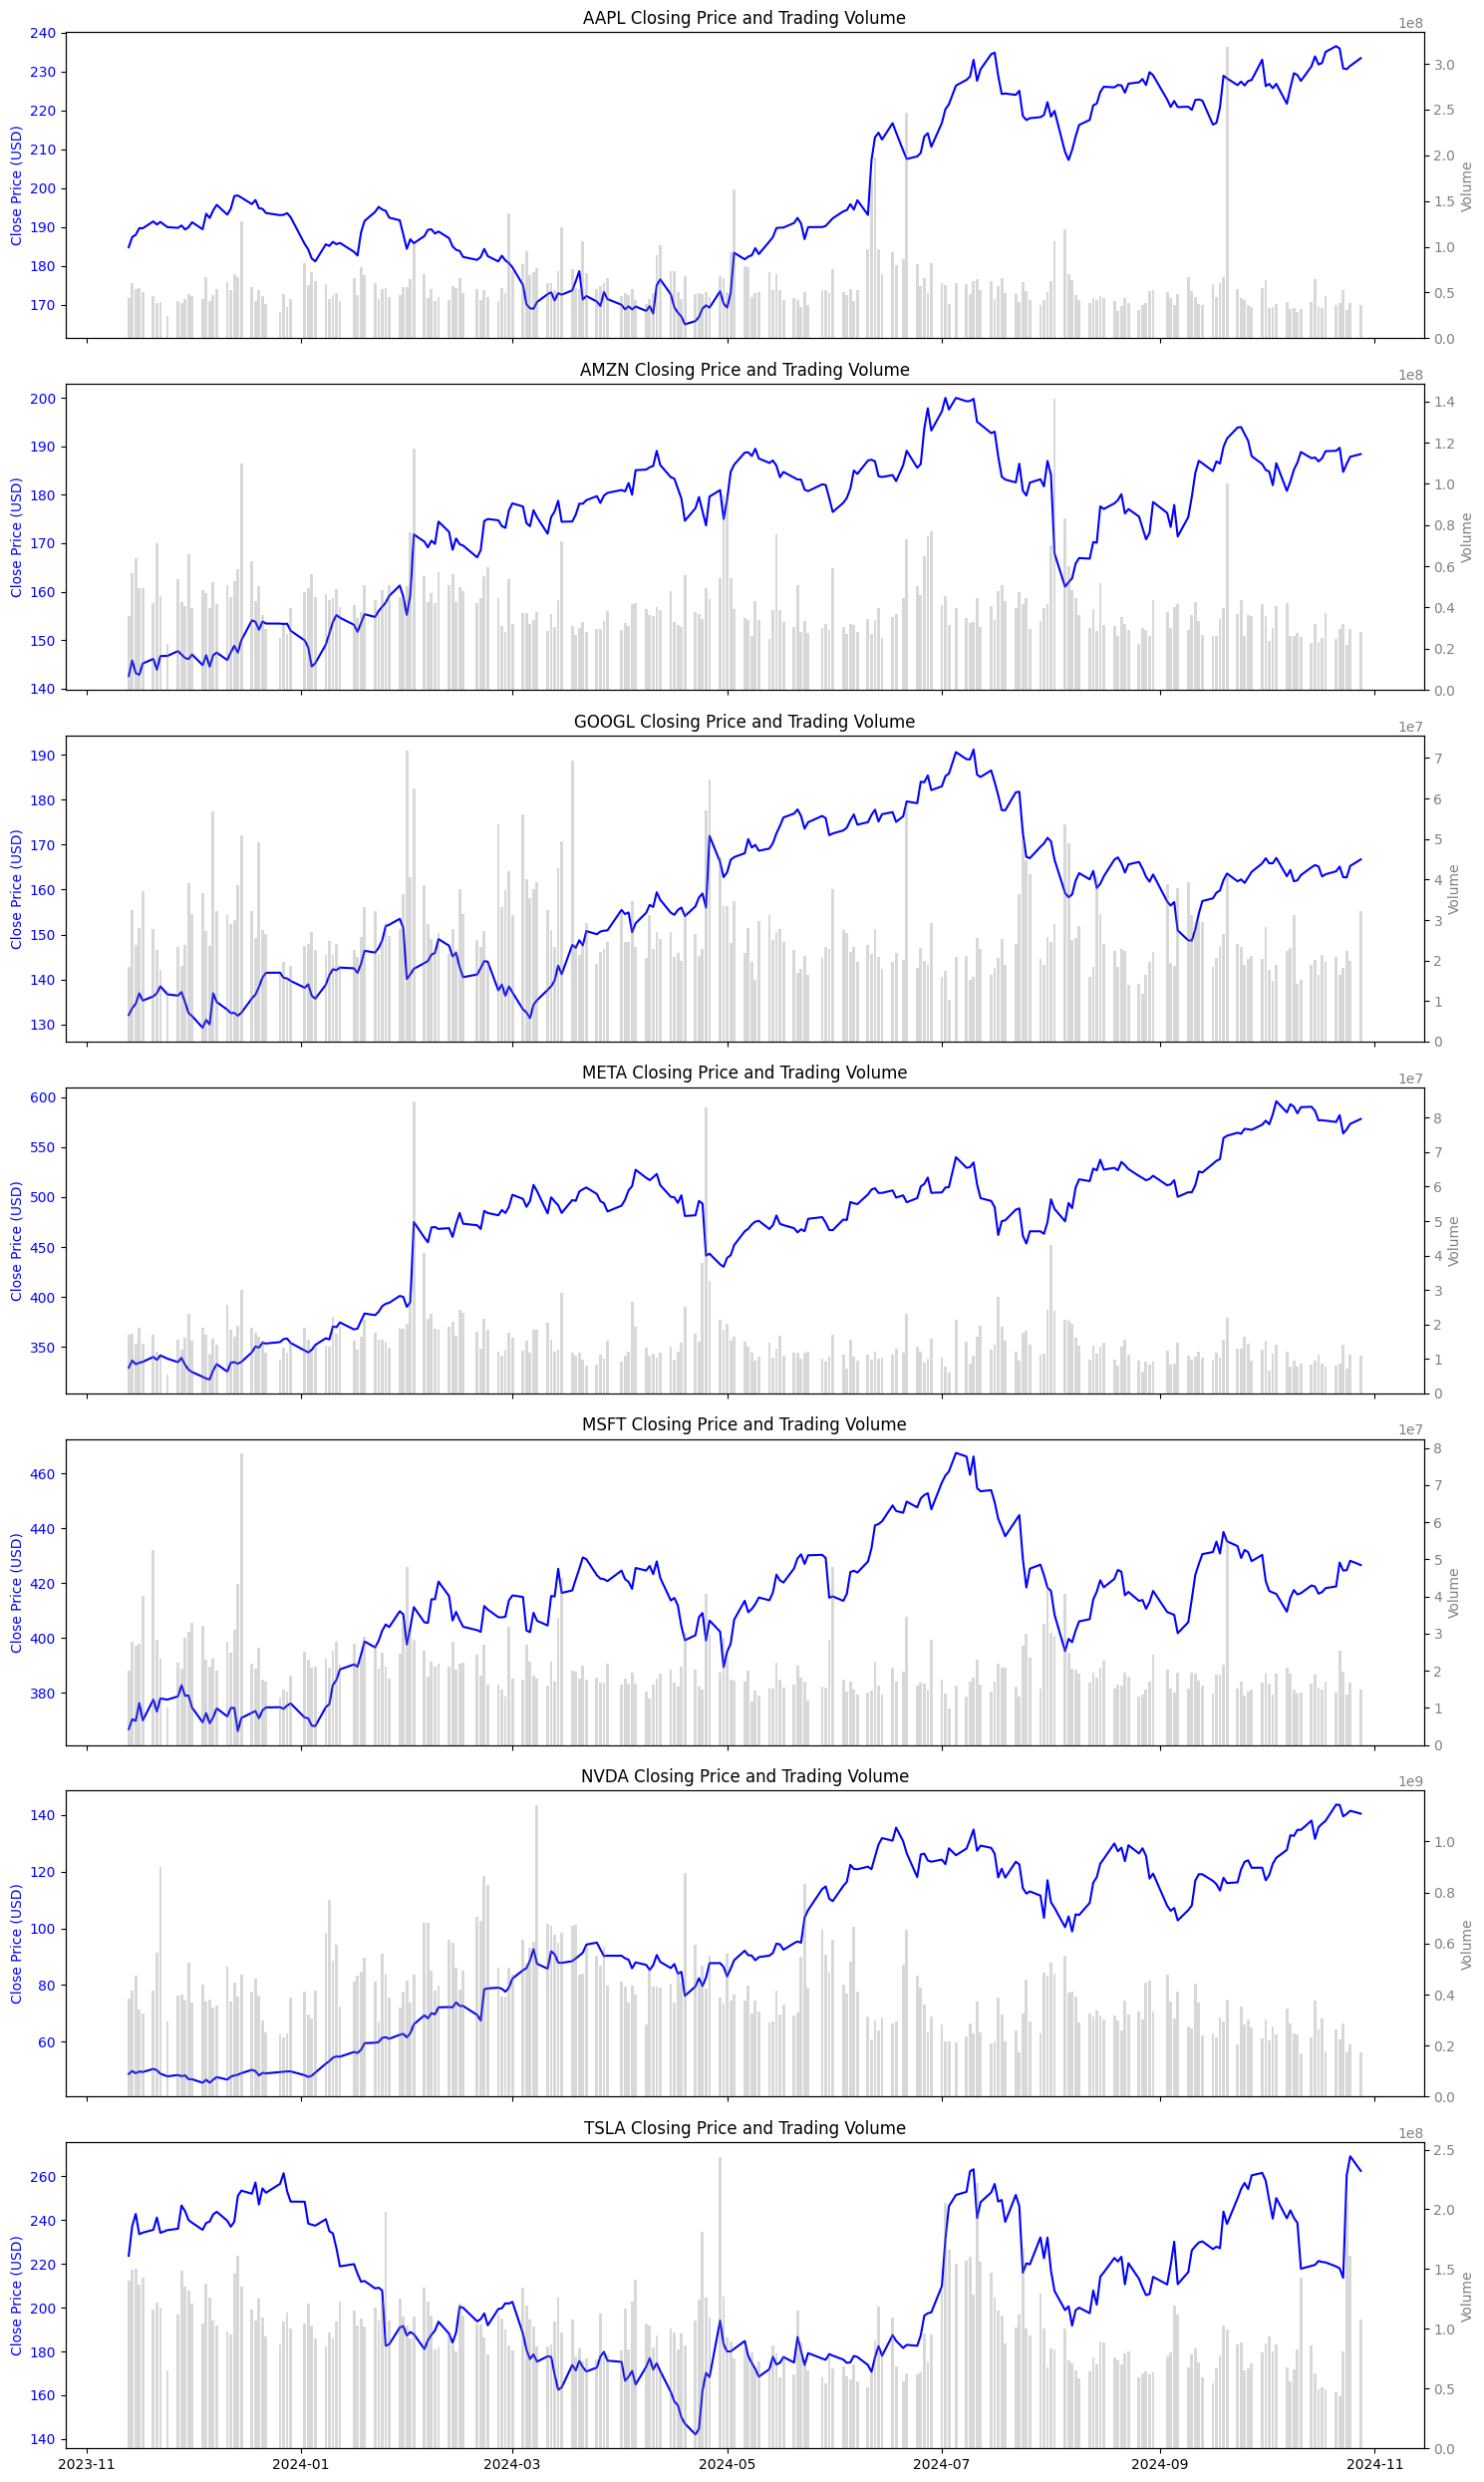

In [19]:
import matplotlib.pyplot as plt

tickers = ["AAPL", "AMZN", "GOOGL", "META", "MSFT", "NVDA", "TSLA"]

fig, axes = plt.subplots(len(tickers), 1, figsize=(15, 25), sharex=True)

for i, ticker in enumerate(tickers):
    ticker_df = df[df['ticker'] == ticker].copy()

    ax1 = axes[i]
    ax1.plot(ticker_df['date'], ticker_df['close'], color='blue', label='Close Price')
    ax1.set_ylabel("Close Price (USD)", color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')

    ax2 = ax1.twinx()
    ax2.bar(ticker_df['date'], ticker_df['volume'], color='gray', alpha=0.3, label='Volume')
    ax2.set_ylabel("Volume", color='gray')
    ax2.tick_params(axis='y', labelcolor='gray')

    ax1.set_title(f"{ticker} Closing Price and Trading Volume")

plt.xlabel("Date")
plt.tight_layout()
plt.show()


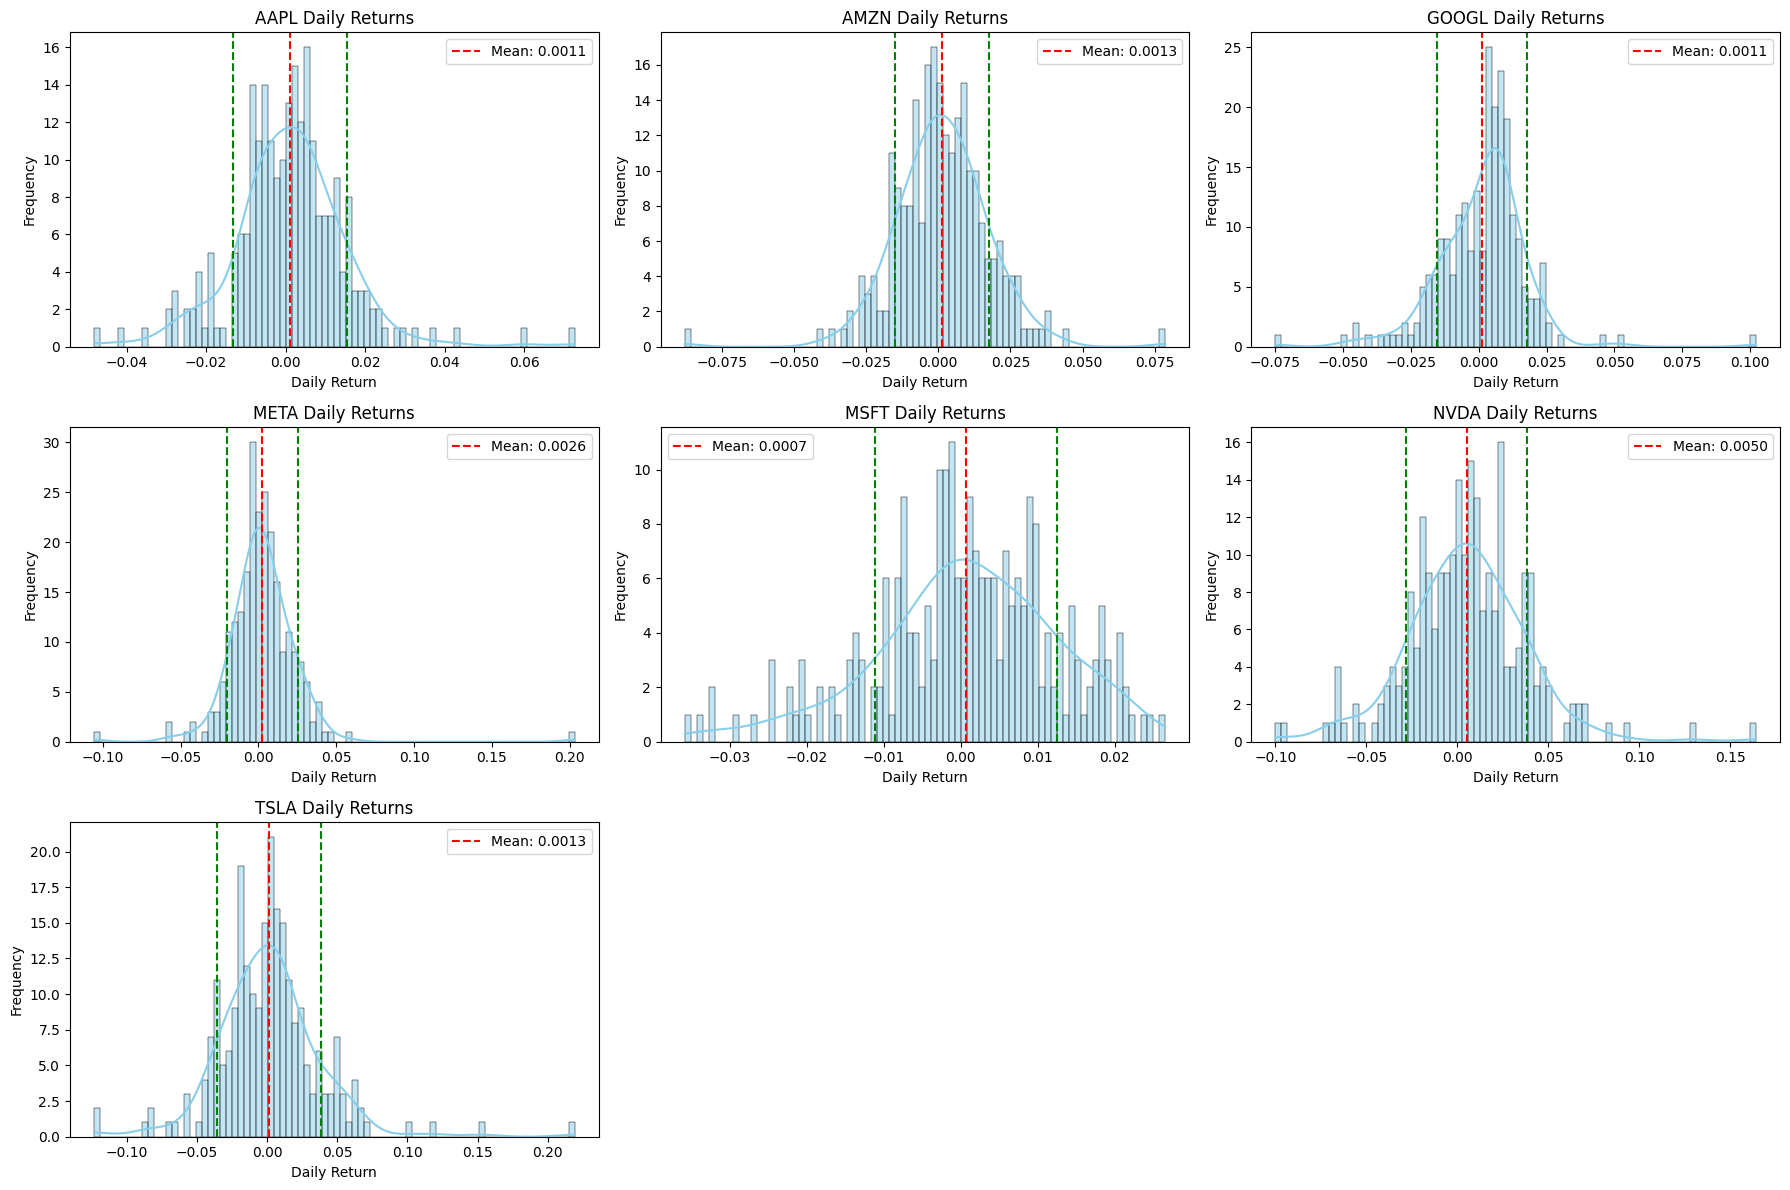

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

tickers = ["AAPL", "AMZN", "GOOGL", "META", "MSFT", "NVDA", "TSLA"]

fig, axes = plt.subplots(3, 3, figsize=(18, 12))
axes = axes.flatten()

for i, ticker in enumerate(tickers):
    ticker_df = df[df['ticker'] == ticker].copy()
    ticker_df['daily_return'] = ticker_df['close'].pct_change()

    mean = ticker_df['daily_return'].mean()
    std = ticker_df['daily_return'].std()

    sns.histplot(
        ticker_df['daily_return'].dropna(),
        bins=80, kde=True, color="skyblue", ax=axes[i]
    )
    axes[i].axvline(mean, color='red', linestyle='--', label=f"Mean: {mean:.4f}")
    axes[i].axvline(mean + std, color='green', linestyle='--')
    axes[i].axvline(mean - std, color='green', linestyle='--')
    axes[i].set_title(f"{ticker} Daily Returns")
    axes[i].set_xlabel("Daily Return")
    axes[i].set_ylabel("Frequency")
    axes[i].legend()

# Hide any unused subplots (since we only have 7 tickers, not 9)
for j in range(len(tickers), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


/var/folders/jx/h6_17scd2ds968lm5w48zw6r0000gn/T/ipykernel_14750/2237925795.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  returns_df['daily_return'] = returns_df.groupby('ticker')['close'].pct_change()


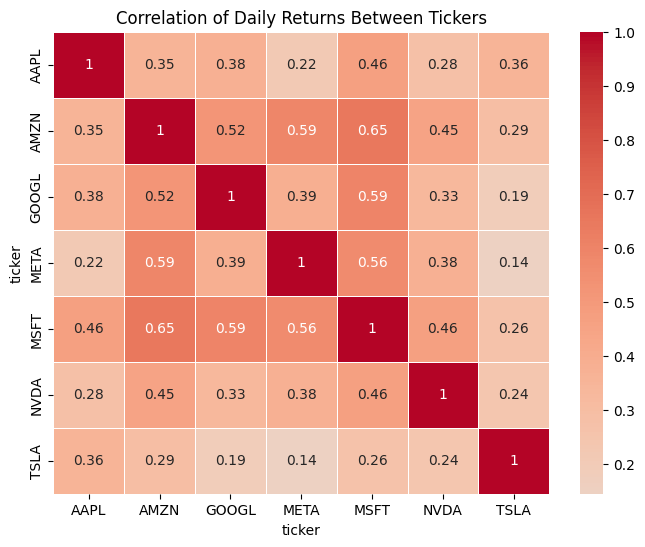

In [23]:
# Pivot returns: rows = date, cols = ticker, values = daily return
returns_df = df.copy()
returns_df['daily_return'] = returns_df.groupby('ticker')['close'].pct_change()

returns_pivot = returns_df.pivot(index='date', columns='ticker', values='daily_return')

# Correlation between tickers
corr_matrix = returns_pivot.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", center=0, linewidths=.5)
plt.title("Correlation of Daily Returns Between Tickers")
plt.show()


Daily Return Statistics by Ticker
        count    mean     std    skew  kurtosis  ann_mean  ann_vol  sharpe
ticker                                                                    
TSLA      240  0.0013  0.0371  0.9755    6.3403    0.3368   0.5882  0.5727
NVDA      240  0.0050  0.0330  0.3825    2.8865    1.2521   0.5239  2.3899
META      240  0.0026  0.0229  2.3301   25.8252    0.6557   0.3631  1.8056
GOOGL     240  0.0011  0.0166  0.2371    7.4854    0.2790   0.2630  1.0606
AMZN      240  0.0013  0.0165 -0.1899    4.7303    0.3267   0.2611  1.2509
AAPL      240  0.0011  0.0143  0.5133    3.9051    0.2707   0.2267  1.1943
MSFT      240  0.0007  0.0118 -0.4690    0.3800    0.1764   0.1869  0.9440


/var/folders/jx/h6_17scd2ds968lm5w48zw6r0000gn/T/ipykernel_14750/3882834608.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tmp['daily_return'] = tmp.groupby('ticker')['close'].pct_change()
/var/folders/jx/h6_17scd2ds968lm5w48zw6r0000gn/T/ipykernel_14750/3882834608.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = tmp.groupby('ticker')['daily_return']
/var/folders/jx/h6_17scd2ds968lm5w48zw6r0000gn/T/ipykernel_14750/3882834608.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the

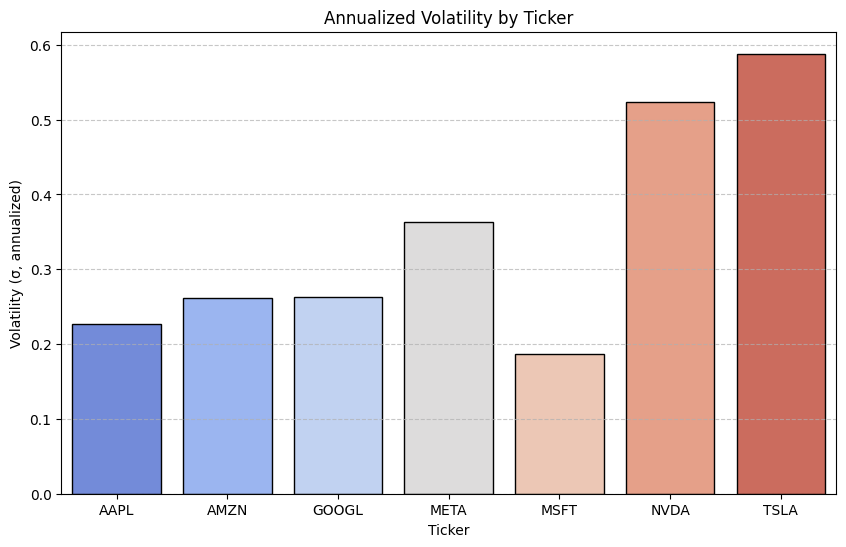

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare returns
tmp = df.sort_values(['ticker', 'date']).copy()
tmp['daily_return'] = tmp.groupby('ticker')['close'].pct_change()
tmp = tmp.dropna(subset=['daily_return'])

TRADING_DAYS = 252
g = tmp.groupby('ticker')['daily_return']

# Build summary safely (no .agg with 'kurt' string)
summary = pd.DataFrame({
    'count':    g.count(),
    'mean':     g.mean(),
    'std':      g.std(),
    'skew':     g.skew(),
    'kurtosis': g.apply(pd.Series.kurt),     # Fisher kurtosis (0 = normal)
})

# Annualized metrics
summary['ann_mean'] = summary['mean'] * TRADING_DAYS
summary['ann_vol']  = summary['std']  * np.sqrt(TRADING_DAYS)
summary['sharpe']   = np.where(summary['ann_vol'] != 0,
                               summary['ann_mean'] / summary['ann_vol'], np.nan)

summary = summary.sort_values('ann_vol', ascending=False)

print("Daily Return Statistics by Ticker")
print(summary.round(4))

# ---- Visualization: Annualized Volatility
plt.figure(figsize=(10, 6))
sns.barplot(x=summary.index, y=summary['ann_vol'], palette="coolwarm", edgecolor="black")
plt.title("Annualized Volatility by Ticker")
plt.ylabel("Volatility (σ, annualized)")
plt.xlabel("Ticker")
plt.grid(axis='y', linestyle="--", alpha=0.7)
plt.show()


In [16]:
import numpy as np
import pandas as pd

# Ensure a clean copy, proper dtypes, and chronological order
ticker_df = ticker_df.copy()
ticker_df = ticker_df.sort_values('date')
ticker_df['close'] = pd.to_numeric(ticker_df['close'], errors='coerce')

# --- Technical Indicators ---

# 1) Moving averages (use min_periods to reduce early NaNs)
ticker_df['sma_20'] = ticker_df['close'].rolling(window=20, min_periods=5).mean()
ticker_df['ema_20'] = ticker_df['close'].ewm(span=20, adjust=False).mean()

# 2) RSI (Wilder’s smoothing)
delta = ticker_df['close'].diff()
gain = delta.clip(lower=0)
loss = -delta.clip(upper=0)

avg_gain = gain.ewm(alpha=1/14, adjust=False, min_periods=14).mean()
avg_loss = loss.ewm(alpha=1/14, adjust=False, min_periods=14).mean()

rs = avg_gain / avg_loss.replace(0, np.nan)
rsi = 100 - (100 / (1 + rs))
# Handle edge cases explicitly:
rsi = rsi.fillna(50)                                # neutral early on
rsi = np.where(avg_loss == 0, 100, rsi)             # all gains -> RSI=100
rsi = np.where((avg_gain == 0) & (avg_loss > 0), 0, rsi)  # all losses -> RSI=0
ticker_df['rsi'] = rsi

# 3) Bollinger Bands (+ extra features)
mid = ticker_df['close'].rolling(window=20, min_periods=20).mean()
std = ticker_df['close'].rolling(window=20, min_periods=20).std()
ticker_df['bb_mid']  = mid
ticker_df['bb_high'] = mid + 2 * std
ticker_df['bb_low']  = mid - 2 * std
# %B and Bandwidth
ticker_df['bb_percent_b'] = (ticker_df['close'] - ticker_df['bb_low']) / (ticker_df['bb_high'] - ticker_df['bb_low'])
ticker_df['bb_bandwidth'] = (ticker_df['bb_high'] - ticker_df['bb_low']) / ticker_df['bb_mid']

# --- News Sentiment ---
# If 'headline' at this point is the daily aggregated headline string for (ticker, date),
# TextBlob is okay as a baseline, but VADER/FinBERT is better for finance.
from textblob import TextBlob

ticker_df['sentiment'] = ticker_df['headline'].astype(str).apply(lambda x: TextBlob(x).sentiment.polarity)

# IMPORTANT: avoid same-day leakage -> shift one day forward before modeling
ticker_df['sentiment_lag1'] = ticker_df['sentiment'].shift(1)

print("Feature engineering complete.")
print(ticker_df[['date', 'close', 'sma_20', 'rsi', 'bb_percent_b', 'sentiment', 'sentiment_lag1']].tail())


Feature engineering complete.
          date       close    sma_20        rsi  bb_percent_b  sentiment  \
236 2024-10-22  235.860001  229.5075  62.115698      0.898476   0.000000   
237 2024-10-23  230.759995  229.7270  52.593027      0.565812   0.115909   
238 2024-10-24  230.570007  229.8795  52.271542      0.544344   0.000000   
239 2024-10-25  231.410004  230.0605  53.621400      0.587071   0.000000   
240 2024-10-28  233.399994  230.0805  56.742653      0.713242   0.159943   

     sentiment_lag1  
236       -0.400000  
237        0.000000  
238        0.115909  
239        0.000000  
240        0.000000  
